In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
# task = 'PerceptualDecisionMaking-v0'
task = 'ContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20}#, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [3]:


class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask to the absolute values of the weights to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        return F.relu(self.weight) * self.mask

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0.1, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self._sigma_rec = np.sqrt(2 * alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

    def recurrence(self, input, hidden):
        """Recurrence helper with a single hidden tensor."""
        total_input = self.input2h(input) + self.h2h(hidden)
        state = hidden * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return output

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden



In [4]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.input_size = input_size
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=7, out_features=128, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=102, out_features=3, bias=True)
)
Step 10, Loss 1.0158
Step 20, Loss 0.5637
Step 30, Loss 0.3145
Step 40, Loss 0.2689
Step 50, Loss 0.2397
Step 60, Loss 0.2333
Step 70, Loss 0.2148
Step 80, Loss 0.2010
Step 90, Loss 0.2100
Step 100, Loss 0.1961
Step 110, Loss 0.1961
Step 120, Loss 0.1908
Step 130, Loss 0.1864
Step 140, Loss 0.1790
Step 150, Loss 0.1717
Step 160, Loss 0.1762
Step 170, Loss 0.1633
Step 180, Loss 0.1691
Step 190, Loss 0.1598
Step 200, Loss 0.1617
Step 210, Loss 0.1558
Step 220, Loss 0.1517
Step 230, Loss 0.1480
Step 240, Loss 0.1474
Step 250, Loss 0.1435
Step 260, Loss 0.1373
Step 270, Loss 0.1401
Step 280, Loss 0.1348
Step 290, Loss 0.1312
Step 300, Loss 0.1327
Step 310, Loss 0.1247
Step 320, Loss 0.1286
Step 330, Loss 0.1242
Step 340, Loss 0.1243
Step 350, Loss 0.1205
Step 360, Loss 0.1159
Step 370, Loss 0.1091
Step 380, Loss 0.1

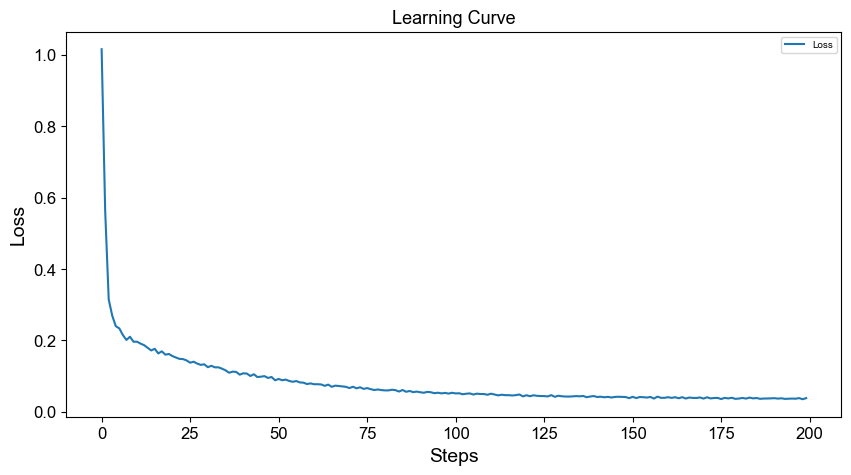

In [17]:

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 128

EI_net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.0)
print(EI_net)

# Use Adam optimizer
optimizer = optim.Adam(EI_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 10
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = EI_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

df = pd.DataFrame(loss_values)
df.to_csv('/Users/edatkinson/4th Year/CogAI/Assessment/loss_values_EI.csv', index=False)


# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [18]:
# @title Run the network post-training and record neural activity
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['axes.titlesize'] = 13  # Title font size
env.reset(no_step=True)
# env.timing.update({'fixation': ('constant', 500),
#                    'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], [], []]  # response for ground-truth 0 and 1 or 2
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = EI_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]
    print('Trial {}, Correct: {}, Choice: {}, Ground truth: {}'.format(i, correct, choice, gt[-1]))

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    # rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]

    stim_activity[env.trial['ground_truth']].append(rnn_activity)


print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))



Trial 0, Correct: False, Choice: 1, Ground truth: 2
Trial 1, Correct: False, Choice: 1, Ground truth: 2
Trial 2, Correct: True, Choice: 1, Ground truth: 1
Trial 3, Correct: False, Choice: 1, Ground truth: 2
Trial 4, Correct: False, Choice: 1, Ground truth: 2
Trial 5, Correct: True, Choice: 1, Ground truth: 1
Trial 6, Correct: True, Choice: 1, Ground truth: 1
Trial 7, Correct: False, Choice: 1, Ground truth: 2
Trial 8, Correct: False, Choice: 1, Ground truth: 2
Trial 9, Correct: False, Choice: 1, Ground truth: 2
Trial 10, Correct: True, Choice: 1, Ground truth: 1
Trial 11, Correct: False, Choice: 1, Ground truth: 2
Trial 12, Correct: False, Choice: 1, Ground truth: 2
Trial 13, Correct: False, Choice: 1, Ground truth: 2
Trial 14, Correct: True, Choice: 1, Ground truth: 1
Trial 15, Correct: False, Choice: 1, Ground truth: 2
Trial 16, Correct: False, Choice: 1, Ground truth: 2
Trial 17, Correct: False, Choice: 1, Ground truth: 2
Trial 18, Correct: True, Choice: 1, Ground truth: 1
Trial 19,

Text(0.5, 1.0, 'Network connectivity: E-I RNN')

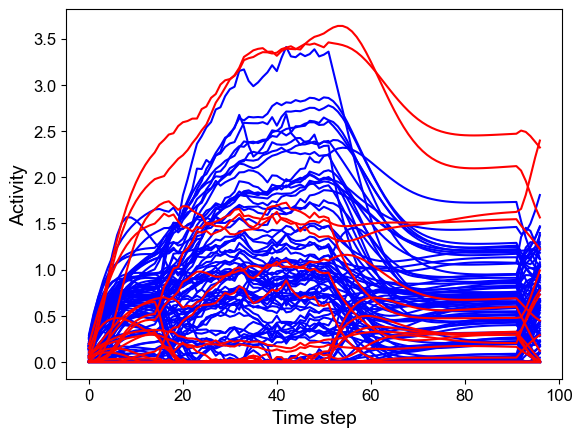

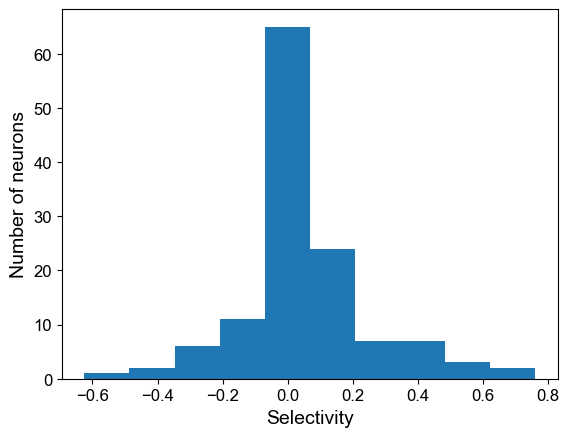

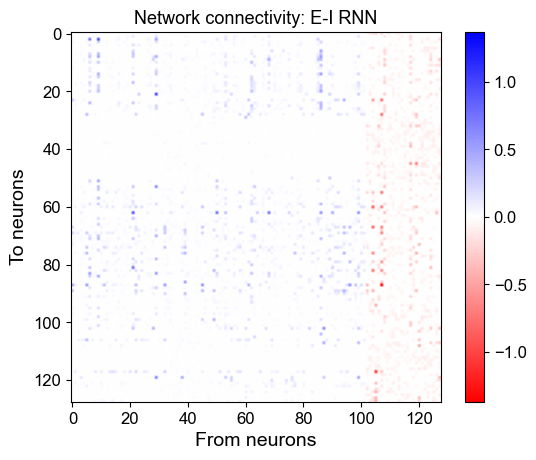

In [19]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = EI_net.rnn.e_size
trial = 1

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')


# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [1,2]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = EI_net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity: E-I RNN')

Confusion Matrix:
[[234   0]
 [266   0]]


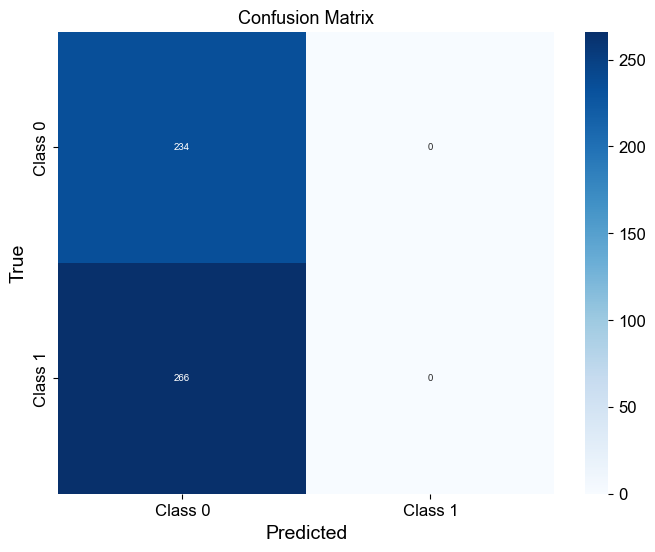

              precision    recall  f1-score   support

     Class 0       0.47      1.00      0.64       234
     Class 1       0.00      0.00      0.00       266

    accuracy                           0.47       500
   macro avg       0.23      0.50      0.32       500
weighted avg       0.22      0.47      0.30       500



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
all_choices = []
all_ground_truths = []

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = EI_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Store predictions and ground truth
    all_choices.append(choice)
    all_ground_truths.append(gt[-1])


from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(all_ground_truths, all_choices)

print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot with class names (e.g., 0 and 1 for binary classification)
plot_confusion_matrix(conf_matrix, class_names=['Class 0', 'Class 1'])

from sklearn.metrics import classification_report

print(classification_report(all_ground_truths, all_choices, target_names=['Class 0', 'Class 1']))

In [9]:
%cd fixed-point-finder
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

/Users/edatkinson/4th Year/CogAI/Assessment/fixed-point-finder


In [10]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [11]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(EI_net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, EI_net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, EI_net.input_size)  # Zero input for each initial condition


# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

print('Initial hidden states shape:', init_hidden_np.shape)
print('Inputs shape:', inputs_np.shape)

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

Initial hidden states shape: (10, 50)
Inputs shape: (10, 7)

Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		976 iters
		q = 4.13e-02 +/- 8.40e-04
		dq = 0.00e+00 +/- 0.00e+00
		learning rate = 1.32e-06
		avg iter time = 3.04e-04 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



In [21]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 50


# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]
# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))


# Visualization


# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color, alpha=0.08)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color, alpha=0.5)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='green', marker='x', s=100, label='Fixed Points')



# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

# for i in range(20):  # Fewer trials for clarity
#     activity_pc_trial = pca.transform(activity_dict[i])  # Project activity for each trial
#     # Color by ground truth
#     trial = trial_infos[i]
#     color = 'red' if trial['ground_truth'] == 0 else 'blue'

#     plt.plot(range(50), activity_pc_trial[:plot_until_time, 0], color=color, label=f'Trial {i+1}', alpha=0.5)
#     plt.xlabel('Time Step')
#     plt.ylabel('PC 1')
#     plt.title('Temporal Dynamics in PC Space')
#     # ax4.legend(loc='upper left')

# # Final adjustments
# plt.tight_layout()
# plt.show()


Shape of the neural activity (Time points, Neurons): (50142, 128)
Shape of the projected activity (Time points, PCs): (50142, 2)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 1 has size 50

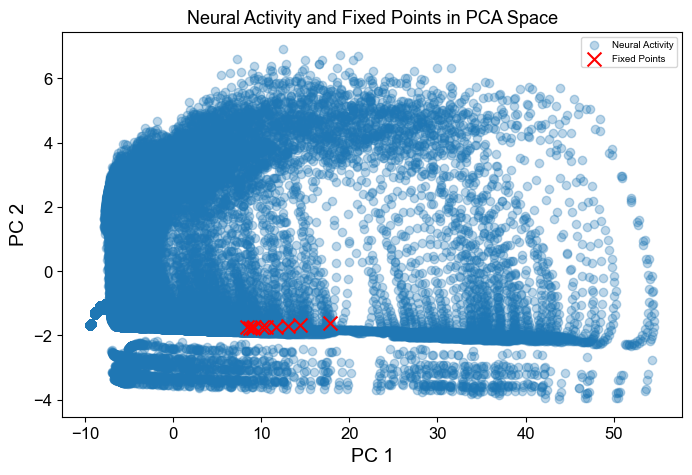

In [13]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		900 iters
		q = 3.70e-01 +/- 1.47e-03
		dq = 0.00e+00 +/- 0.00e+00
		learning rate = 1.88e-06
		avg iter time = 2.90e-04 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		955 iters
		q = 1.65e-01 +/- 1.96e-03
		dq = 0.00e+00 +/- 0.00e+00
		learni

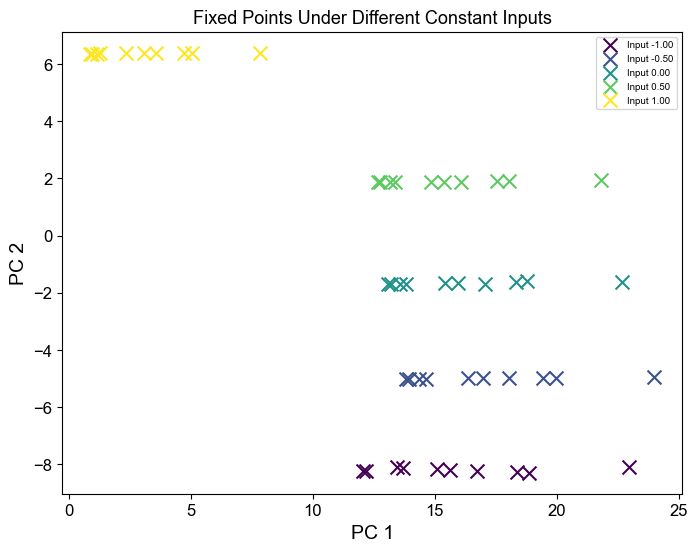

In [14]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, EI_net.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()



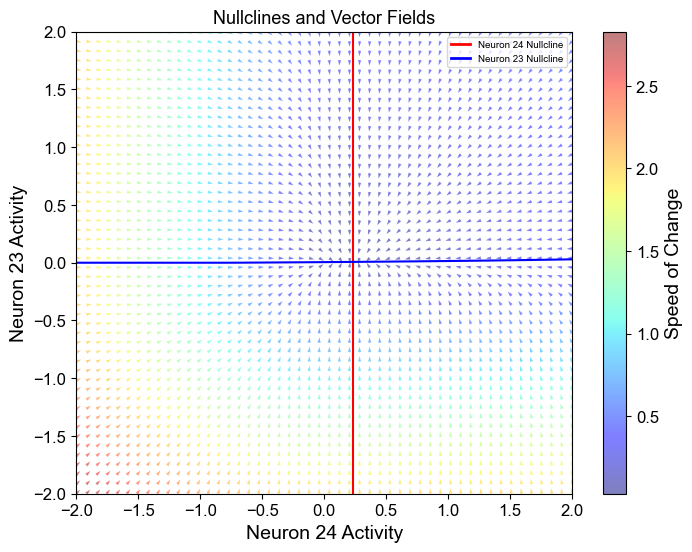

In [15]:
from matplotlib.lines import Line2D

# Select two neurons with highest selectivity
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

# Define ranges for the two neurons
n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

# Flatten the grids
grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

# Prepare inputs (constant zero input)
inputs = torch.zeros(grid_states.shape[0], EI_net.input_size).type(torch.float32)

# Prepare initial states for all neurons, keeping other neurons at zero
initial_states = np.zeros((grid_states.shape[0], EI_net.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]

# Convert to torch tensors
initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)

# Run one step of the RNN
_, next_states = EI_net.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()

# Compute derivatives for the two neurons
d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]

# Reshape to grid
d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

# Compute vector field
U = d_neuron1_grid  # Change in neuron1
V = d_neuron2_grid  # Change in neuron2

# Normalize the vector field for better visualization
speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

# Plot nullclines and vector field
plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

# legend entries
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.xlabel(f'Neuron {neuron1} Activity')
plt.ylabel(f'Neuron {neuron2} Activity')
plt.title('Nullclines and Vector Fields')
plt.colorbar(label='Speed of Change')
plt.show()
